# Prediction of Winter Wheat Yield Loss using Climatic Data

### By Maria Gil Rodriguez

## 1) Introduction

The annual crop yield represents the amount of product harvested by unit of area in a given year, often expressed in tonnes per hectare. In the case of winter wheat, the yield corresponds to the quantity of grain.

The yield depends on the characteristics of the region where the wheat is grown and the climatic conditions in that region (temperature, radiation, precipitation, etc.). The value is likely to vary greatly between regions and between years.

It is important to predict a potential loss before harvest. In France, the wheat harvest is usually held in July. Pre-harvest yield loss predictions provide the possibility for regional economic operators to plan their harvest, manage their stocks and to optimize their contracts (purchases and sales of grain). Predictions also constitute strategic information used to operate in international markets.

The objective of this capstone is to develop models to **classify as accurately as possible the wheat Yield Loss in France**.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
from collections import Counter
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn import metrics
from scipy import stats
current_palette = sns.color_palette('mako_r',12)
sns.set_palette(current_palette)

%matplotlib inline

## 2) Exploring the Data

The dataset we are using in this capstone can be found in Kaggle (https://www.kaggle.com/ociule/crop-data-challenge-2018-cland) and was part of a Challenge that, the French Institute of convergence CLAND (http://cland.lsce.ipsl.fr/index.php), organized as part of a conference in December 2018. 

In [2]:
df_raw = pd.read_csv('TrainingDataSet_Wheat.csv')
df_raw.head()

,year_harvest,NUMD,ETP_1,ETP_10,ETP_11,ETP_12,ETP_2,ETP_3,ETP_4,ETP_5,...,Tx34_10,Tx34_11,Tx34_12,Tx34_2,Tx34_3,Tx34_4,Tx34_5,Tx34_6,Tx34_9,Class
0,3,1,0.225639,0.610201,0.374210,0.232291,0.573471,1.416320,1.55965,2.51640,...,0.0,0,0,0,0,0,0.0,0.0,0.0,1
1,4,1,0.376123,0.697921,0.327242,0.305836,0.402265,0.989877,1.85831,2.02216,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0
2,5,1,0.201415,0.790845,0.269794,0.225611,0.349833,0.920070,1.32144,2.47706,...,0.0,0,0,0,0,0,0.0,0.0,0.0,1
3,6,1,0.235087,0.769788,0.518969,0.206574,0.444469,0.510438,1.73645,2.41834,...,0.0,0,0,0,0,0,0.0,0.0,0.0,1
4,7,1,0.295047,0.595156,0.306547,0.293618,0.529465,1.089250,1.29556,2.28783,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0


**Metadata**

The dataset includes the following columns:

* Class: variable equal to 1 in case of **loss of wheat yield** and 0 otherwise. This is the target variable to predict.

* year_harvest: year harvest (1 to 58). Year 58 corresponds to 2017.

* NUMD: number indicating the department (from 1 to 94).

For the climatic data 1 corresponds to January and 12 to December

* ETP_1 ... ETP_12: Monthly average potential evapotranspiration per year and by department (mm/day)

* PR_1 ... PR_12: Monthly cumulative precipitation per year by department (mm/day)

* RV_1 ... RV_12: Average monthly radiation per year and per department (W/$m^{2}$)

* SeqPR1 ... SeqPR12: Monthly number of rainy days per year per department

* Tn_1 ... Tn_12: Average monthly minimum daily temperature per year and by department (degrees C)

* Tx_1 ... Tx_12: Average monthly maximum daily temperature per year and by department (degrees C)

* Tn17.2_1 ... Tn17.2_12: Number of days where the minimum daily temperature is less than -17 degrees C for each month per year and per department 
 
* Tx010_1 ... Tx010_12: Number of days where the daily maximum temperature is between zero and 10 degrees C for each month per year and per department

* Tx34_1 ... Tx34_12: Number of days where the daily maximum temperature is greater than 34 degrees C for each month per year and per department 
 
Note that the values of the climatic variables for the months 9 to 12 correspond to the year preceding the crop year. The values of climatic variables for months 1 to 6 correspond to the values obtained the harvest year. All these values are available before July and can therefore be used directly to predict pre-harvest performance. The values of the variables 7 and 8 months are absent.

In [3]:
print(df_raw.shape)
df_raw.describe()

(3571, 93)


,year_harvest,NUMD,ETP_1,ETP_10,ETP_11,ETP_12,ETP_2,ETP_3,ETP_4,ETP_5,...,Tx34_10,Tx34_11,Tx34_12,Tx34_2,Tx34_3,Tx34_4,Tx34_5,Tx34_6,Tx34_9,Class
count,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,...,3571.000000,3571.0,3571.0,3571.0,3571.0,3571.0,3571.000000,3571.000000,3571.000000,3571.000000
mean,30.154018,47.482498,0.446367,1.009352,0.541752,0.413977,0.727805,1.344957,2.066147,2.830258,...,0.000002,0.0,0.0,0.0,0.0,0.0,0.000962,0.080498,0.008942,0.214786
std,16.270880,27.104051,0.166863,0.305715,0.188248,0.168326,0.234694,0.375662,0.465245,0.579789,...,0.000142,0.0,0.0,0.0,0.0,0.0,0.014433,0.327656,0.101415,0.410731
min,3.000000,1.000000,0.107838,0.174475,0.161847,0.080465,0.214385,0.384638,0.910013,1.272820,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,17.000000,24.000000,0.328816,0.786026,0.407692,0.296152,0.561676,1.083780,1.734510,2.430450,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,30.000000,48.000000,0.423913,0.989662,0.519169,0.389246,0.699722,1.311830,2.027560,2.796770,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,44.000000,71.000000,0.539257,1.196085,0.637523,0.495145,0.868854,1.577720,2.354605,3.214030,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
max,58.000000,94.000000,1.514980,2.343190,1.604470,1.468390,2.037880,2.954790,3.943750,4.796450,...,0.008475,0.0,0.0,0.0,0.0,0.0,0.406780,4.672410,4.176470,1.000000


### *Distributions:*

Let's now take a look of the distributions. Because of the big number of variables, we are going to represent only the month of October (expect for Tn17.2_11 that corresponds to November because in October it was invariable).

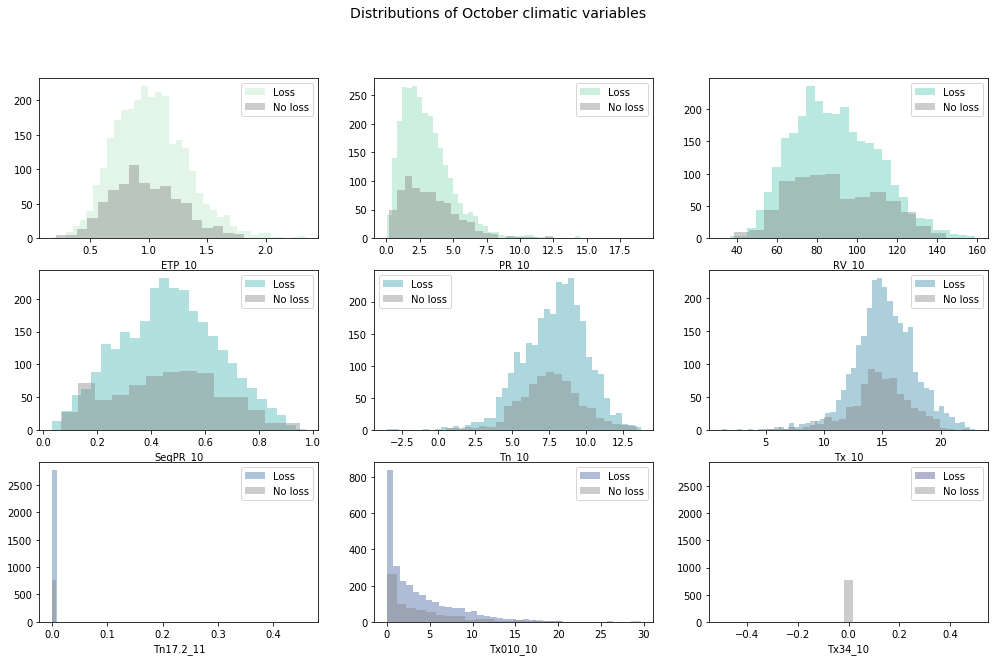

In [4]:
fig = plt.figure(figsize=(17,10),)

oct_variables = ['ETP_10', 'PR_10','RV_10', 'SeqPR_10', 'Tn_10', 'Tx_10', 'Tn17.2_11', 'Tx010_10', 'Tx34_10']
i=1
for variable in oct_variables:
    plt.subplot(3,3,i)
    sns.distplot(df_raw.loc[df_raw['Class']==0, variable], color=current_palette[i-1], label='Loss', kde=False)
    sns.distplot(df_raw.loc[df_raw['Class']==1, variable], color='gray', label='No loss', kde=False)
    plt.legend()
    i+=1
fig.suptitle('Distributions of October climatic variables', fontsize=14)
plt.show()


Most of the distributions are pretty normal. PR is slightly skewed. The frecuencies of extreme temperatures Tn17.2_10, Tx010_10 and Tx34_10 are really skewed, as we could expect of extreme values.

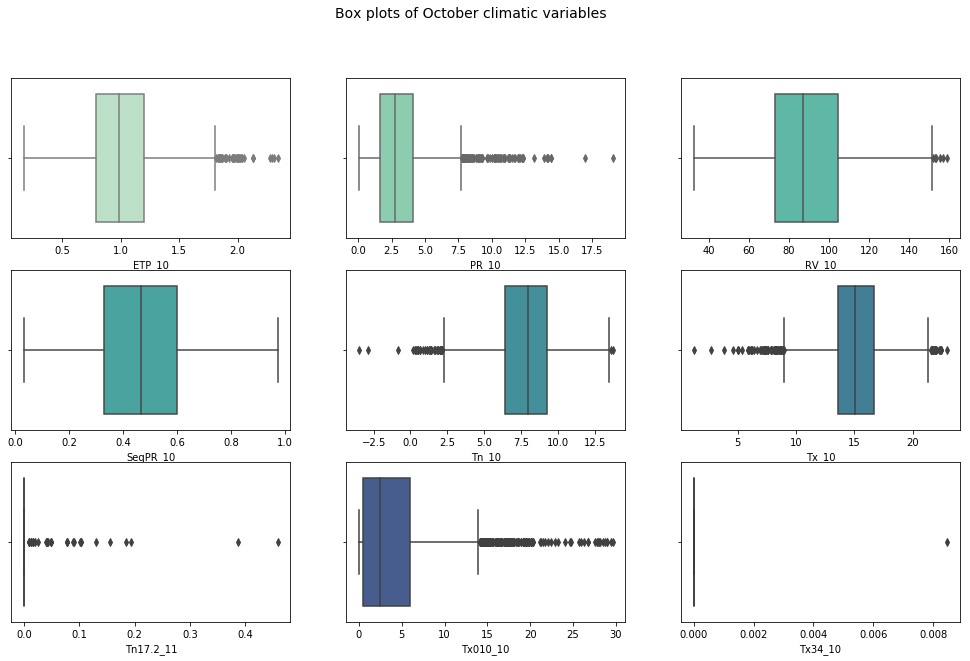

In [5]:
fig = plt.figure(figsize=(17,10))
oct_variables = df_raw[['ETP_10', 'PR_10','RV_10', 'SeqPR_10', 'Tn_10', 'Tx_10', 'Tn17.2_11', 'Tx010_10', 'Tx34_10']]
i=1
for variable in oct_variables:
    plt.subplot(3,3,i)
    sns.boxplot(df_raw[variable], color=current_palette[i-1])
    i+=1
    
fig.suptitle('Box plots of October climatic variables', fontsize=14)
plt.show()

In [6]:
df = df_raw.loc[:, (df_raw != 0).any(axis=0)] # Eliminate the constant variables
print(len(df))
print(len(df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]))

3571
944


From the boxplots, we can see how noisy the data is. In the dataset almost 3/4 of the data points are more than two standard deviations away from the average value.

## Correlations

Let's now take a look a to the correlations.

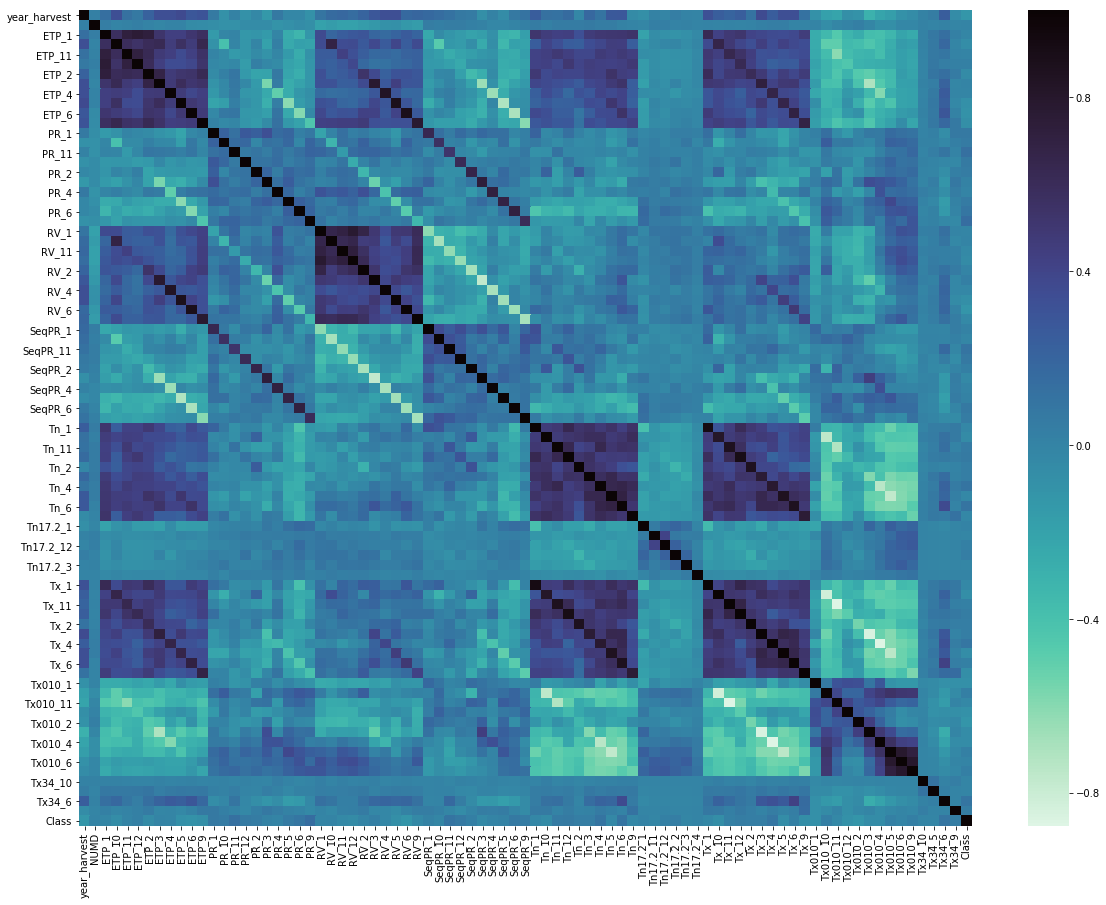

In [7]:
plt.figure(figsize=(20,15))
corr_mat = df.corr()
sns.heatmap(corr_mat, cmap='mako_r')
plt.show()

All the climatic data in a month: temperature, rain, evapotranspiration and radiation are correlated. That is why we can see the small squares with small diagonal lines. This is an intrinsec characteristic of our dataset and it is difficult to eliminate correlated variables without getting rid of information. 

## 3) Pre-processing

### *Data Cleaning:*

Since the dataset was prepared for the Challenge it is very clean. However, some of the columns of the numbers of days with  extreme temperatures are straight zeros. These are not missing data, it just shows that there were zero days in that month with the corresponding characteristics. 

Models do not like constant features because they add no information. Thus, we are going to drop those columns.

We will also drop 'NUMD' and 'year_harvest'. 

Finally, we separate the dataframe in X, the features, and Y, the outcome we want to predict.

In [8]:
#df = df_raw.loc[:, (df_raw != 0).any(axis=0)] #We already did this to have a pretty correlation matrix

# Create dataframe X with all the potential features 
X = df.drop(['Class', 'year_harvest', 'NUMD'], axis=1)
Y = df.Class
print(X.shape)
print(Y.shape)

(3571, 80)
(3571,)


### *Feature Engineering:*

In previous versions of this notebook, we created some new features like monthly mean temperature, monthly water deficit, annual mean temperature... But after testing the models with them, we concluded that the new features didn't add any improvement, so we decided to omit them in this version. 

### *Train and test set* 

We are going to randomly split the dataset in train and test sets with a 75/25 ratio. 

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2678, 80)
(893, 80)
(2678,)
(893,)


### *Normalization:*

The features have different units and orders of magnitud. Therefore, we are going to normalize our sets before starting the feature selection.

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train= min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### *Feature selection*

For feature selection, we will try two approaches: Random forest feature inportance and PCA:

#### Feature Importance

In [11]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,Y_train) 

print(cross_val_score(rfc, X_train, Y_train, cv=5))
print(rfc.score(X_test, Y_test))

[0.83054004 0.82649254 0.84859813 0.82429907 0.8635514 ]
0.8667413213885778


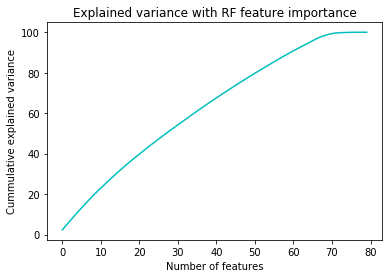

In [12]:
sorted_feature_importance = sorted(rfc.feature_importances_, reverse=True)
plt.plot(np.cumsum(sorted_feature_importance)*100., color='c')
plt.xlabel('Number of features')
plt.ylabel('Cummulative explained variance')
plt.title('Explained variance with RF feature importance')
plt.show()

From the plot, we can see that most of the features contribute roughly the same to the total variance, except for the last 15 ones. Let's try PCA and compare.  

#### PCA

In [14]:
pca = PCA(n_components=80)
X_PCA = pca.fit_transform(X_train)

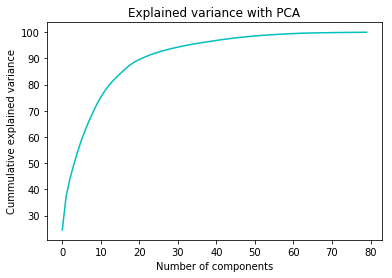

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100., color='c')
plt.xlabel('Number of components')
plt.ylabel('Cummulative explained variance')
plt.title('Explained variance with PCA')
plt.show()

In [16]:
n_components = 17
np.sum(pca.explained_variance_ratio_[:n_components])

0.8553770751760521

There is a vast difference. In the case of PCA, with only 17 features (components) we can explain 85% of the variance whereas in Feature Importance we would need around 65 features.

Why did PCA work so well? Since the many features for the same months are correlated, their vectors are close in the space, and the components are able to group them.

Let's transform the train and test set and continue.

In [17]:
X_train = X_PCA[:,:n_components]
X_test_PCA = pca.transform(X_test)
X_test = X_test_PCA[:,:n_components]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2678, 17)
(893, 17)
(2678,)
(893,)


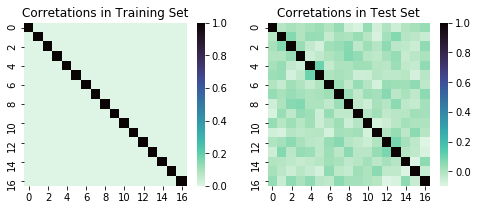

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
corr_mat = X_train.corr()
plt.title('Corretations in Training Set')
sns.heatmap(corr_mat, cmap='mako_r')

plt.subplot(1,2,2)
corr_mat = X_test.corr()
sns.heatmap(corr_mat, cmap='mako_r')
plt.title('Corretations in Test Set')
plt.show()

As we can see, the correlations were mostly eliminated by PCA.

### *Class imbalance:*

Our outcome variable has a class imbalance. We are going to oversample the training set with SMOTE.

In [19]:
print('Training set:\t', sorted(Counter(Y_train).items()))
print('Test set\t', sorted(Counter(Y_test).items()))


Training set:	 [(0, 2096), (1, 582)]
Test set	 [(0, 708), (1, 185)]


In order to perform cross-validating with oversampling, we will do the following:
Inside the cross-validation loop, we will get a sample out and do not use it for anything related oversampling or model building. We will then oversample our minority class, without the excluded sample. Finally, we will use the excluded sample for validation, and the oversampled minority class + the majority class, to create the model.

If we would not do this and oversample before creating the folds, the cross-validation values will be overestimated because the validation set would be oversampled, too, filtering some information.

## 4) Supervised Learning Models

It's time to do some modeling. Because in the Challenge the goal was to get the behighest ROC-AUC score, we will use it to score our models. It also turned out to be the scoring that gave the best overall results. 

In [20]:
# Define a function to print the models' results
def model_results(model, y_pred):
    print('Train set score:\t\t', round(model.score(X_train, Y_train),2))
    print('Best cross validation score:\t', round(model.best_score_,2))
    print('Test set score:\t\t\t', round(model.score(X_test, Y_test),2))
    print('Report:')
    print(classification_report(Y_test, y_pred))
    conf_mat = confusion_matrix(Y_test, y_pred)
    sns.heatmap(conf_mat,annot=True, cbar=True, fmt='d',cmap='mako_r')
    plt.show()

In [21]:
# Create DataFrame to store results
results = pd.DataFrame(columns=['auc', 'fpr', 'tpr']) 

### *Random Forest:*

Train set score:		 1.0
Best cross validation score:	 0.88
Test set score:			 0.89
Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       708
           1       0.66      0.68      0.67       185

   micro avg       0.86      0.86      0.86       893
   macro avg       0.79      0.79      0.79       893
weighted avg       0.86      0.86      0.86       893



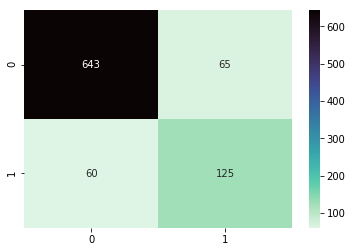

In [22]:
pipe1 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('rfc', RandomForestClassifier(random_state=27, n_jobs=-1))
    ])

param_grid = {'rfc__max_depth': [20, 50, 100],
              'rfc__max_features': ['auto'],
              'rfc__min_samples_leaf': [1, 2],
              'rfc__min_samples_split': [2, 3],
              'rfc__n_estimators': [1000, 2000],
              'rfc__criterion': ['gini', 'entropy']}
grid_rfc = GridSearchCV(pipe1, param_grid, return_train_score=False,
                    n_jobs=-1, cv=5, scoring='roc_auc')
grid_rfc.fit(X_train, Y_train)

#Store results
y_pred_proba = grid_rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
results.loc[0, :] = [grid_rfc.score(X_test, Y_test), fpr, tpr]

# Print results
y_pred = grid_rfc.predict(X_test)
model_results(grid_rfc, y_pred)

### *Gradient Boosting:*

Train set score:		 1.0
Best cross validation score:	 0.87
Test set score:			 0.88
Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       708
           1       0.66      0.68      0.67       185

   micro avg       0.86      0.86      0.86       893
   macro avg       0.79      0.79      0.79       893
weighted avg       0.86      0.86      0.86       893



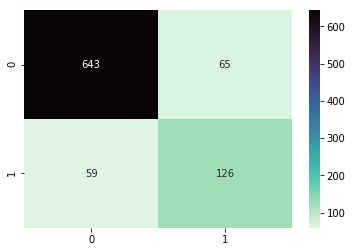

In [23]:
pipe2 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('gbc', GradientBoostingClassifier(random_state=27))
    ])

param_grid = {'gbc__loss': ['deviance', 'exponential'],
              'gbc__learning_rate': [0.01, 0.1, 1],
              'gbc__n_estimators': [100],
              'gbc__max_depth': [5, 10, 15]}
grid_gbc = GridSearchCV(pipe2, param_grid, return_train_score=False, n_jobs=-1, cv=5, scoring='roc_auc')
grid_gbc.fit(X_train, Y_train)

#Store results
y_pred_proba = grid_gbc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
results.loc[1, :] = [grid_gbc.score(X_test, Y_test), fpr, tpr]

# Print results
y_pred = grid_gbc.predict(X_test)
model_results(grid_gbc, y_pred)

### *KNN:*

Train set score:		 0.92
Best cross validation score:	 0.86
Test set score:			 0.88
Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       708
           1       0.46      0.83      0.59       185

   micro avg       0.76      0.76      0.76       893
   macro avg       0.70      0.79      0.71       893
weighted avg       0.84      0.76      0.78       893



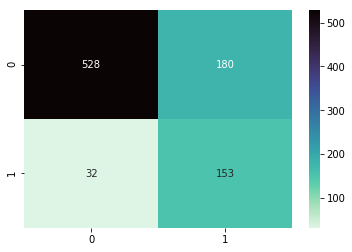

In [34]:
pipe3 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('knn', KNeighborsClassifier())
    ])

param_grid = {'knn__n_neighbors': [10, 20, 30],
              'knn__weights': ['uniform'],
              'knn__p': [1, 2]}
grid_knn = GridSearchCV(pipe3, param_grid, return_train_score=False, n_jobs=-1, cv=5, scoring='roc_auc')
grid_knn.fit(X_train, Y_train)

#Store results
y_pred_proba = grid_knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
results.loc[2, :] = [grid_knn.score(X_test, Y_test), fpr, tpr]

# Print results
y_pred = grid_knn.predict(X_test)
model_results(grid_knn, y_pred)

### *Logistic Regression:*

Train set score:		 0.68
Best cross validation score:	 0.66
Test set score:			 0.66
Report:
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       708
           1       0.31      0.65      0.42       185

   micro avg       0.62      0.62      0.62       893
   macro avg       0.59      0.63      0.57       893
weighted avg       0.75      0.62      0.66       893



C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


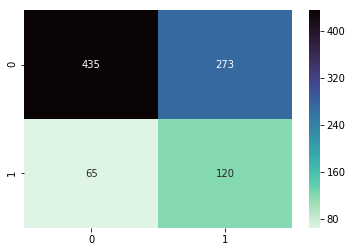

In [24]:
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import StratifiedKFold
pipe4 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('lr', LogisticRegression(random_state=27))
    ])

param_grid = {'lr__C': [.1, 1, 10],
              'lr__penalty': ['l2', 'l1']} #, 
grid_lr = GridSearchCV(pipe4, param_grid, return_train_score=False,
                    n_jobs=-1, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, Y_train)

#Store results
y_pred_proba = grid_lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
results.loc[3, :] = [grid_lr.score(X_test, Y_test), fpr, tpr]

# Print results
y_pred = grid_lr.predict(X_test)
model_results(grid_lr, y_pred)

### *SVC:*

Train set score:		 0.96
Best cross validation score:	 0.85
Test set score:			 0.87
Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       708
           1       0.54      0.74      0.63       185

   micro avg       0.82      0.82      0.82       893
   macro avg       0.73      0.79      0.75       893
weighted avg       0.85      0.82      0.83       893



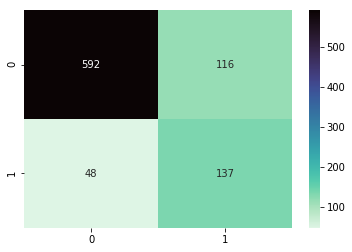

In [25]:
pipe5 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('svc', SVC(random_state=27, probability=True))
    ])

param_grid = {'svc__gamma': ['auto', 'scale'],
              'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'svc__C': [100, 1000],}
grid_svc = GridSearchCV(pipe5, param_grid, return_train_score=False, n_jobs=-1, cv=5, scoring='roc_auc')
grid_svc.fit(X_train, Y_train)

#Store results
y_pred_proba = grid_svc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
results.loc[4, :] = [grid_svc.score(X_test, Y_test), fpr, tpr]

# Print results
y_pred = grid_svc.predict(X_test)
model_results(grid_svc, y_pred)

### *Discussion:*

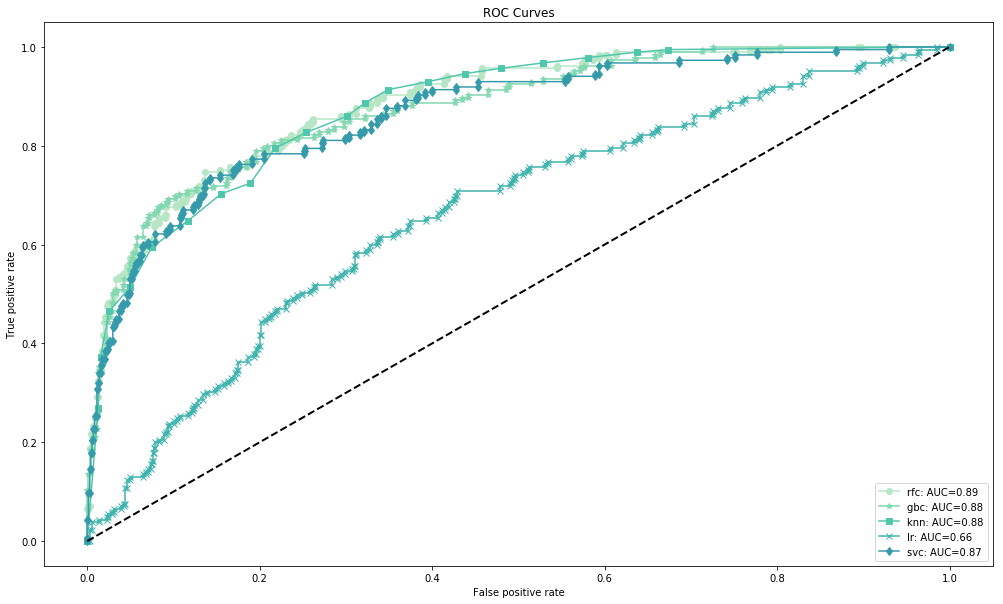

In [37]:
models = ['rfc', 'gbc', 'knn', 'lr', 'svc']
markers = ['o', '*', 's', 'x', 'd']
plt.figure(figsize=(17,10))
i = 0
for model in models:
    plt.plot(results.fpr[i],results.tpr[i],label=(model+': AUC='+str(round(results.auc[i], 2))), marker=markers[i])
    i += 1
             
x = [0.0, 1.0]
plt.plot(x, x, linestyle='dashed', color='k', linewidth=2)
plt.legend(loc=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curves')
plt.show()

* All the models overfitted due to the noisy nature of the dataset. In orther to prevent this, it would be convenient to have more data. Reducing features didn't help and if we were to select less than the 17 we did, we would start underfitting. 

* Random Forest slightly outperform other supervised machine learning methods. As expected, the results for Gradient Boosting were very similar.

* KNN performed surprisingly well. However, the precission for the minority class was poor.

* Logistic Regression perfored poorly.

## 5) Conclusions 

* Climate variables are relatively good predictors of wheat yield classes in France.

* Random Forest was the best model, with an area under the ROC curve of 0.89.

* The results would be much better with a less noisy data. That could be achived by working with local data (vs generalized for an entire Department) or using the data of several stations for one Department.  


## 6) Future Work

* France has five different climates. Thus, performing some clustering before using our supervised models would be ideal and most likely improve the results. 

* There is also some information in the NUMD variable that might be worth to explore.

## 7) References:

https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

https://elitedatascience.com/overfitting-in-machine-learning

http://cland.lsce.ipsl.fr/attachments/article/36/DataChallenge_Intro.pdf